# Two Gaussian distributions

Fewer examples than before, less variance in the data, and an example that is anomalous in only one coordinate. 

/var/folders/b4/my86xy1s7kd2m9bg9txms_yc0000gn/T/ipykernel_69170/2536608215.py:16: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples1 = np.random.multivariate_normal(mean1, cov1, n1)
/var/folders/b4/my86xy1s7kd2m9bg9txms_yc0000gn/T/ipykernel_69170/2536608215.py:23: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples2 = np.random.multivariate_normal(mean2, cov2, n2)


(np.float64(-3.699156189897473),
 np.float64(5.319560931630092),
 np.float64(-3.608775434185403),
 np.float64(5.409941687342163))

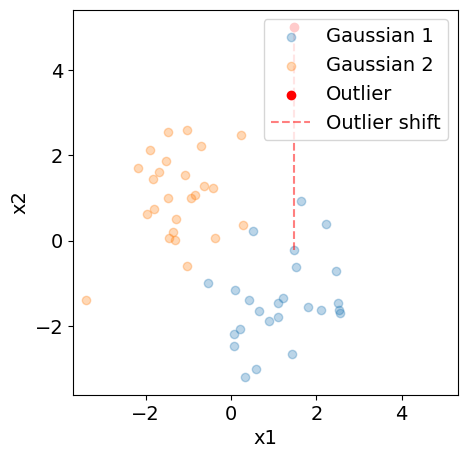

In [73]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set figure font size
plt.rcParams.update({'font.size': 14})

# Set random seed for reproducibility
np.random.seed(42)

# Generate samples from first Gaussian
n1 = 25 
mean1 = [1.1, -1.1]
cov1 = np.array([[1, 1], [0, 1]])
cov1 = 1*cov1 
samples1 = np.random.multivariate_normal(mean1, cov1, n1)

# Generate samples from second Gaussian
n2 = 25 
mean2 = [-1.1,  1.1] 
cov2 = np.array([[1, 1], [0, 1]]) 
cov2 = 1*cov2 
samples2 = np.random.multivariate_normal(mean2, cov2, n2)

# Combine samples
X = np.vstack([samples1, samples2])

outlier_index = 20
original_example = X[outlier_index, :].copy()
X[outlier_index, 1] = 5 # Set an extreme value 

plt.figure(figsize=(5,5))
plt.scatter(samples1[:,0], samples1[:,1], alpha=0.3, label='Gaussian 1')
plt.scatter(samples2[:,0], samples2[:,1], alpha=0.3, label='Gaussian 2')
plt.scatter(X[outlier_index, 0], X[outlier_index, 1], color='red', label='Outlier')

# Draw line between original and modified outlier position
plt.plot([original_example[0], X[outlier_index,0]], 
         [original_example[1], X[outlier_index,1]], 
         'r--', alpha=0.5, label='Outlier shift')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.axis('square')

# Principal Components and why they're useful

We want to find the direction along which the data vary most and least. 
Finding these directions, called principal components, can be very useful when your data is high-dimensional but only a few of the directions account for most of the variation. For example, if the data lived in 1000-dimensional space, but almost all of the variation occurred along a particular direction, you could approximate each data-point quite well using its projection onto that direction. That would aid visualization and allow you to compress the data because each data point would now be represented by a single coordinate instead of 1000 of them (see later).

# Singular Value Decomposition (SVD)

SVD can be used to find the principal components of a data set. 

Let $X$ be the $m\times n$ matrix whose rows are the data-points. There are $m$ data points and each data point has $n$ dimensions. Decompose $X$ using the Singular Value Decomposition (SVD):

$$X = U \Sigma V^T$$

Here, $\Sigma$ is a diagonal matrix whose diagonal entries are positive and in decreasing order (the largest lies in the upper left corner of $\Sigma$). The other matrices, $U$ and $V$, are orthogonal matrices, i.e. their columns are orthonormal vectors.

The columns of $V$ are the significant directions we were looking for. $\Sigma$'s entries are the amount of variance of the data along those directions. Finally, $U$ (or more precisely $U\Sigma$) stores how you write each row of $X$ in terms of the columns of $V$. 



### Mean normalization

In [74]:
mean_X = np.apply_along_axis(np.mean, 0, X)
X_n = X - mean_X

There is a reason for this "mean normalization": If the mean is not zero, the "most significant direction" will be skewed towards the direction of the mean, and we don't want that.

### Compute the principal components of the data set


In [75]:
import scipy.linalg

U, s, Vt = scipy.linalg.svd(X_n)

In [76]:
# diagonal elements of matrix Sigma
# notice that the singular values are ordered, with largest first
s 

array([13.69325204,  8.36484592])

In [77]:
# Construct the matrix Sigma from the singular values contained in the variable `s`

m = len(U)
n = len(Vt)
Sigma = np.zeros((m, n))
for i in range(min(m, n)):
    Sigma[i, i] = s[i]
    
print('shape of U =', U.shape)
print('shape of Vt (or V) =', Vt.shape)
print('shape of Sigma =', Sigma.shape)

shape of U = (50, 50)
shape of Vt (or V) = (2, 2)
shape of Sigma = (50, 2)


In [78]:
Vt # transpose of matrix V

array([[ 0.56048142, -0.828167  ],
       [ 0.828167  ,  0.56048142]])

(np.float64(-3.6565853676183746),
 np.float64(5.362131753909191),
 np.float64(-3.536805640425718),
 np.float64(5.4819114811018474))

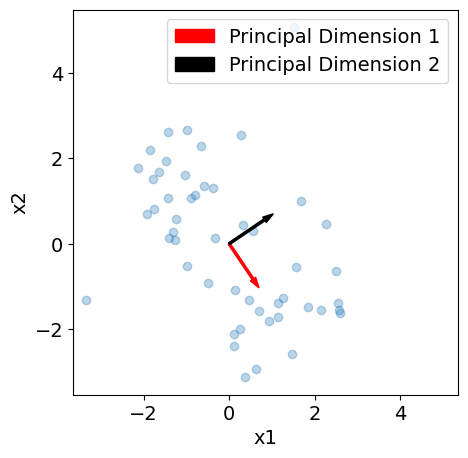

In [79]:
# extract rows of Vt, which are the columns of V
v1 = Vt[0,:]
v2 = Vt[1,:]

plt.figure(figsize=(5,5))
plt.scatter(X_n[:,0], X_n[:,1], alpha=0.3)
plt.arrow(0, 0, v1[0], v1[1], width=0.05, head_width=0.15, head_length=0.25, color="red", label='Principal Dimension 1')
plt.arrow(0, 0, v2[0], v2[1], width=0.05, head_width=0.15, head_length=0.25, color="black", label='Principal Dimension 2')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('square')

# Approximating the data set

Let's now approximate the data set `X_n`. We do this by retaining only the first $k$ of the singular values contained in `s` or, equivalently, by retaining only the first $k$ rows and columns of $\Sigma$. We similarly contract $U$ to one containing just the first $k$ columns and contract $V^T$ to one containing just the first $k$ rows. 

This approximation of the matrix `X_n`, which we'll call `X_n_hat`, is called a **low-rank approximation** because the approximate matrix has rank `k`, which is typically smaller than the rank of `X`. 

Also, it can be shown that the approximation, `X_n_hat`, is the matrix of rank `k` that is closest (under the Frobenius norm) to the original matrix `X_n`. This foreshadows our discussion of autoencoders (below).

In [80]:
# Construct approximations of `X_n` using its SVD and $k=1$
k = 1 
X_n_hat = np.dot(U[:,:k], Sigma[:k,:k]).dot(Vt[:k,:]) 

(np.float64(-3.6565853676183746),
 np.float64(5.362131753909191),
 np.float64(-3.536805640425718),
 np.float64(5.4819114811018474))

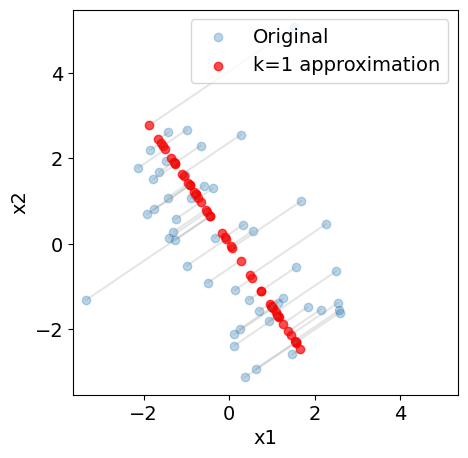

In [81]:
plt.figure(figsize=(5,5))
plt.scatter(X_n[:,0], X_n[:,1], alpha=0.3, label='Original')
plt.scatter(X_n_hat[:,0], X_n_hat[:,1], 
           color='red', alpha=0.7, label=f'k={k} approximation')

# Draw lines between original and approximated points to show the difference
for i in range(len(X_n)):
    plt.plot([X_n[i,0], X_n_hat[i,0]], 
             [X_n[i,1], X_n_hat[i,1]], 
             'gray', alpha=0.2)

plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('square')

Notice that we we can compress the data set using two numbers representing the (red) line (slope and intercept), and one number representing the position of the data points when projected onto the line. 

# PCA is a special case of an autoencoder

The notation I used above is not accidental. For example, I chose to call the projection onto the first principal component `H`, while I called the approximated data `X_n_hat`. That's because `H` is the hidden/latent representation of the data, and `X_n_hat` is the reconstructed data, to use terminology from autoencoders.

So what is an autoencoder? An autoencoder is a type of neural network that is trained to copy its input to its output, by first encoding the input into a latent representation and then decoding the latent representation back into the original space. 

When the encoder is a linear transformation, the decoder is the transpose of the encoder, and the autoencoder is trained to minimize the mean squared error between the input and its reconstruction, it can be shown that the autoencoder is equivalent to PCA: https://photos.app.goo.gl/o6bGCQF2GFj33uFk9 

Epoch [10/10000], Loss: 1.6613
Epoch [20/10000], Loss: 1.4376
Epoch [30/10000], Loss: 1.2618
Epoch [40/10000], Loss: 1.1185
Epoch [50/10000], Loss: 0.9997
Epoch [60/10000], Loss: 0.9063
Epoch [70/10000], Loss: 0.8374
Epoch [80/10000], Loss: 0.7894
Epoch [90/10000], Loss: 0.7571
Epoch [100/10000], Loss: 0.7361
Epoch [110/10000], Loss: 0.7226
Epoch [120/10000], Loss: 0.7140
Epoch [130/10000], Loss: 0.7087
Epoch [140/10000], Loss: 0.7053
Epoch [150/10000], Loss: 0.7032
Epoch [160/10000], Loss: 0.7019
Epoch [170/10000], Loss: 0.7010
Epoch [180/10000], Loss: 0.7005
Epoch [190/10000], Loss: 0.7002
Epoch [200/10000], Loss: 0.7000
Epoch [210/10000], Loss: 0.6999
Epoch [220/10000], Loss: 0.6998
Epoch [230/10000], Loss: 0.6998
Epoch [240/10000], Loss: 0.6998
Epoch [250/10000], Loss: 0.6997
Epoch [260/10000], Loss: 0.6997
Epoch [270/10000], Loss: 0.6997
Epoch [280/10000], Loss: 0.6997
Epoch [290/10000], Loss: 0.6997
Epoch [300/10000], Loss: 0.6997
Epoch [310/10000], Loss: 0.6997
Epoch [320/10000]

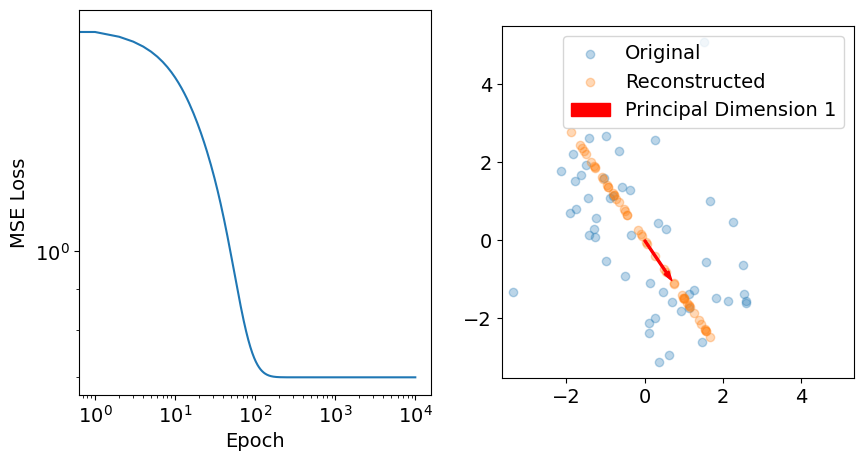

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim

class PCAAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(PCAAutoencoder, self).__init__()
        # Encoder: Linear transformation to latent space
        self.encoder = nn.Linear(input_dim, latent_dim, bias=False)
        # Decoder: Transpose of encoder
        self.decoder = nn.Linear(latent_dim, input_dim, bias=False)
        
        # Tie weights of encoder and decoder (decoder's weights are encoder's transpose)
        self.decoder.weight = nn.Parameter(self.encoder.weight.t())
    
    def forward(self, x):
        # Encode and then decode
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

# Hyperparameters
input_dim = 2  # Example input dimension
latent_dim = 1  # Dimensionality of latent space
learning_rate = 0.01
num_epochs = 10000

# Convert numpy array to torch tensor
X_n_tensor = torch.from_numpy(X_n).float()  # .float() ensures it's a FloatTensor

# Model, loss, optimizer
model = PCAAutoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    reconstructed = model(X_n_tensor)  
    loss = criterion(reconstructed, X_n_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Visualization
plt.figure(figsize=(10, 5))

# Plot loss curve
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.xscale('log')
plt.yscale('log')

# Plot original vs reconstructed data
plt.subplot(1, 2, 2)
with torch.no_grad():
    X_n_hat = model(X_n_tensor).numpy()
    
plt.scatter(X_n[:, 0], X_n[:, 1], alpha=0.3, label='Original')
plt.scatter(X_n_hat[:, 0], X_n_hat[:, 1], alpha=0.3, label='Reconstructed')
plt.arrow(0, 0, v1[0], v1[1], width=0.05, head_width=0.15, head_length=0.25, color="red", label='Principal Dimension 1')
plt.legend()
plt.axis('square')

# Compare with SVD direction
encoder_direction = model.encoder.weight.data[0].numpy()
encoder_direction = encoder_direction / np.linalg.norm(encoder_direction)
print("\nLearned direction:", encoder_direction)
print("SVD direction (v1):", v1)


# Making contact with the Outrider paper 

Considering the coordinates as genes, the coordinate values as expression levels, and the examples as individuals, we can think of the autoencoder as a way of denoising the data, controlling for the hidden structure of the data (the clusters), allowing us to visualize the outlier. 


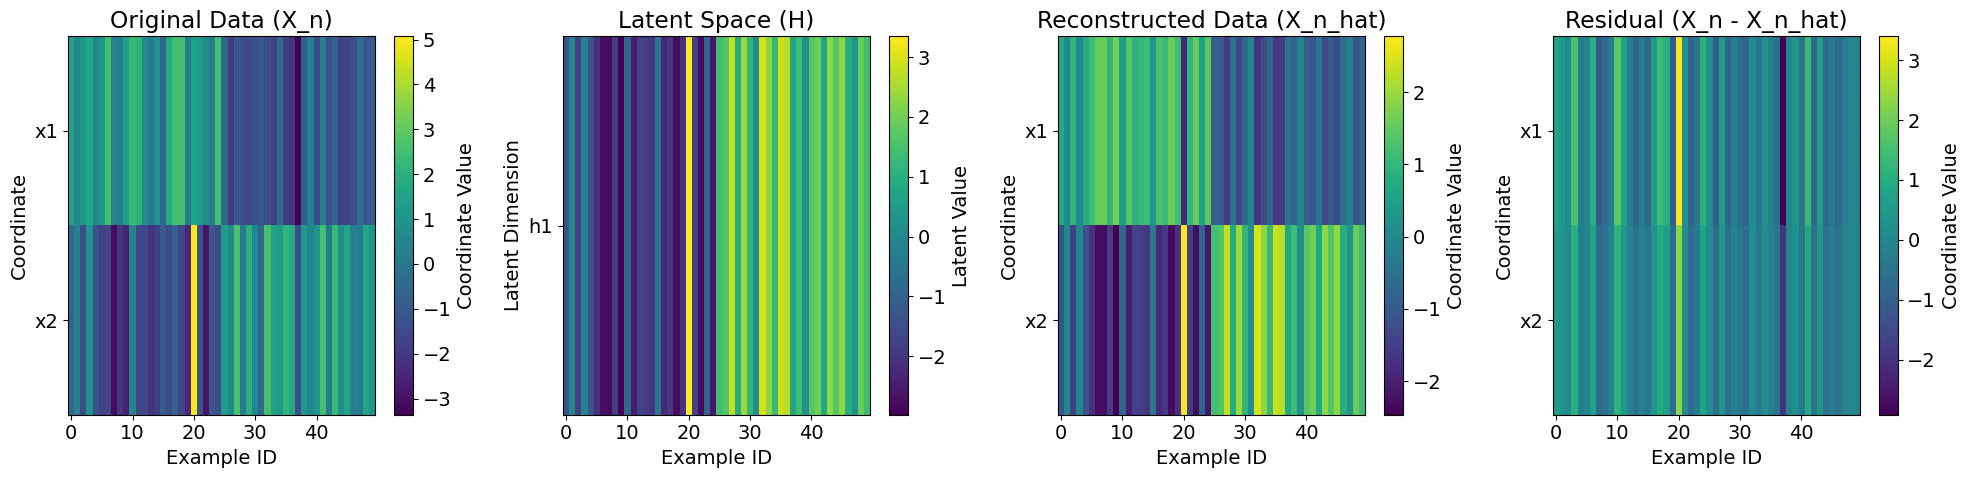

In [83]:
# Create side-by-side heatmaps of original and reconstructed data
plt.figure(figsize=(20, 5))

# Original data heatmap
plt.subplot(1, 4, 1)
plt.imshow(X_n.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Coordinate Value')
plt.xlabel('Example ID')
plt.ylabel('Coordinate')
plt.title('Original Data (X_n)')
plt.yticks([0,1], ['x1', 'x2'])

# Get latent representation (H)
with torch.no_grad():
    H = model.encoder(X_n_tensor).numpy()

# Plot latent representation heatmap between original and reconstructed
plt.subplot(1, 4, 2)
plt.imshow(H.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Latent Value')
plt.xlabel('Example ID')
plt.ylabel('Latent Dimension')
plt.title('Latent Space (H)')
plt.yticks([0], ['h1'])

# Reconstructed data heatmap
plt.subplot(1, 4, 3)
plt.imshow(X_n_hat.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Coordinate Value')
plt.xlabel('Example ID')
plt.ylabel('Coordinate')
plt.title('Reconstructed Data (X_n_hat)')
plt.yticks([0,1], ['x1', 'x2'])

# ratio of original to reconstructed data
plt.subplot(1, 4, 4)
plt.imshow(X_n.T - X_n_hat.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Coordinate Value')
plt.xlabel('Example ID')
plt.ylabel('Coordinate')
plt.title('Residual (X_n - X_n_hat)')
plt.yticks([0,1], ['x1', 'x2'])

plt.tight_layout()

Let's compare this to the [Outrider paper](https://www.cell.com/ajhg/fulltext/S0002-9297(18)30401-4) ("raw counts" corresponds to "original data", while "controlled counts" corresponds to "residuals"):


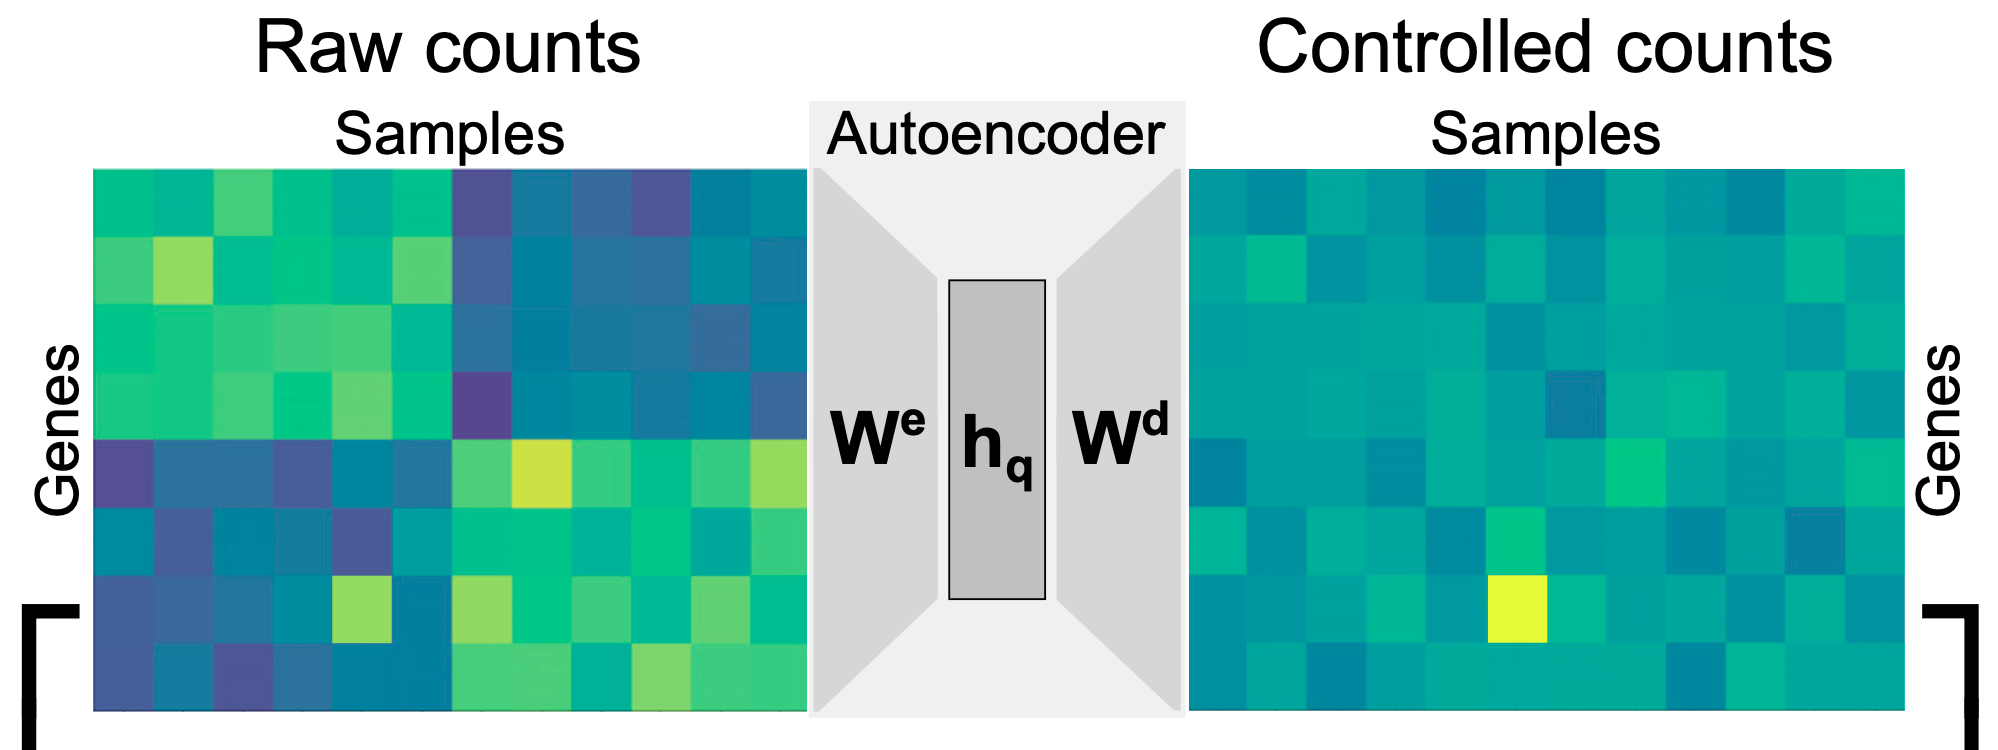

In [84]:
from IPython.display import Image
Image('outrider.png')

Though the images are similar, we see that in the image of our autoenceoder, all genes manifest as outliers in the outlier example, while in the outrider image,  only one gene is an outlier in the outlier sample. Why is this? 

The answer has to do the dimensionality of our simulated data. Given that there are only two coordinates (genes), and the outlier coordinate is so anomalous, our autoencoder realizes, correctly, that there is less recontruction error in assigning the outlier example to the second cluster (examples 26 - 50) than to the first (examples 1 - 25), which is the truth. In other words, it is better to make small errors in both coordinates than to make a large error in only one coordinate. However, this strategy becomes less effective as the dimensionality of the data increases, because then the small errors in the "normal" coordinates will overwhelm the large error in the anomalous coordinate. 

We test this hypothesis in the next notebook. 

